In [9]:
%matplotlib inline
import os
from subprocess import check_call
from glob import glob

import cftime
import xarray as xr
import numpy as np
import xesmf as xe

import woa2013

USER = os.environ['USER']

In [2]:
import importlib
importlib.reload(woa2013)

grid_src = '1x1d'
freq = 'mon'

ds = woa2013.open_dataset(['TEMP','SALT'],grid=grid_src,freq=freq)
ds

<xarray.Dataset>
Dimensions:             (depth: 57, lat: 180, lon: 360, nbounds: 2, time: 12)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 1400.0 1450.0 1500.0
  * time                (time) float64 0.5 1.5 2.5 3.5 4.5 ... 8.5 9.5 10.5 11.5
Dimensions without coordinates: nbounds
Data variables:
    crs                 (time) int32 -2147483647 -2147483647 ... -2147483647
    lon_bnds            (time, lon, nbounds) float32 dask.array<shape=(12, 360, 2), chunksize=(1, 360, 2)>
    depth_bnds          (time, depth, nbounds) float32 dask.array<shape=(12, 57, 2), chunksize=(1, 57, 2)>
    climatology_bounds  (time, nbounds) float32 dask.array<shape=(12, 2), chunksize=(1, 2)>
    TEMP                (time, depth, lat, lon) float32 dask.array<shape=(12, 57, 180, 360), chunksize=(1, 57, 180, 360)>
    lat_bn

In [3]:
def compute_kmt(ds,varname):
    '''Compute an KMT-like index'''
    nk = ds[varname].shape[1]
    #-- init KMT array
    KMT = np.zeros(ds[varname].shape[-2:]).astype(int)

    #-- where surface is missing, KMT = 0, else full depth
    KMT = np.where(np.isnan(ds[varname].values[0,0,:,:]),0,nk)

    #-- loop over k
    #   where level k is missing: KMT = k, i.e. the level above in 1-based indexing
    for k in range(1,nk):
        KMT = np.where(np.isnan(ds[varname].values[0,k,:,:]) & (KMT > k),k,KMT)

    return KMT

def derive_var_MLD(ds, Dsigma=0.03):
    '''Return the mixed layer depth computed from potential density criterion.
    '''
    import popeos

    attrs = ds.TEMP.attrs.copy()
    encoding = ds.TEMP.encoding

    RHO = popeos.eos(SALT=ds.SALT,TEMP=ds.TEMP,DEPTH=0.,PRESS_IN=False)
    RHO = RHO - 1000.

    KMT = compute_kmt(ds,'TEMP').astype(int)
    z_t = ds.depth

    nl, nk, nj, ni = ds.TEMP.shape
    MLD = np.ones((nl, nj, ni)) * np.nan

    for j in range(0,nj):
        for i in range(0,ni):
            kmt = KMT[j,i]
            if kmt == 0: continue
            for l in range(0,nl):
                rho = RHO[l,0:kmt,j,i]
                z = z_t[0:kmt]

                rho, I = np.unique(rho, return_index=True)
                z = z[I]
                if len(I) >= 3:
                    MLD[l,j,i] = np.interp(rho[0]+Dsigma, rho, z)

    ds = ds.drop(['TEMP','SALT'])
    ds = ds.load()
    ds['MLD'] = xr.DataArray(MLD,
                             dims=('time','nlat','nlon'),
                             coords={'time':ds.time},
                             attrs=attrs,
                             encoding=encoding)

    ds.MLD.attrs['long_name'] = 'MLD'
    ds.MLD.attrs['definition'] = f'$\Delta\sigma = {Dsigma:0.3f}$'
    ds.MLD.attrs['units'] = 'm'

    return ds

In [4]:
ds = derive_var_MLD(ds)
ds

<xarray.Dataset>
Dimensions:             (depth: 57, lat: 180, lon: 360, nbounds: 2, nlat: 180, nlon: 360, time: 12)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 1400.0 1450.0 1500.0
  * time                (time) float64 0.5 1.5 2.5 3.5 4.5 ... 8.5 9.5 10.5 11.5
Dimensions without coordinates: nbounds, nlat, nlon
Data variables:
    crs                 (time) int32 -2147483647 -2147483647 ... -2147483647
    lon_bnds            (time, lon, nbounds) float32 -180.0 -179.0 ... 180.0
    depth_bnds          (time, depth, nbounds) float32 0.0 2.5 ... 1475.0 1500.0
    climatology_bounds  (time, nbounds) float32 0.0 1.0 1.0 ... 11.0 11.0 12.0
    lat_bnds            (time, lat, nbounds) float32 -90.0 -89.0 ... 89.0 90.0
    MLD                 (time, nlat, nlon) float64 nan nan nan ... 0.8089 0.8089

In [8]:
weight_file_dir = f'/glade/work/mclong/regrid_xesmf/weight_files'
if not os.path.exists(weight_file_dir):
    check_call(['mkdir','-p',weight_file_dir])
    
method = 'bilinear'

variable = 'MLD'

for grid_dst in ['POP_gx1v6','POP_gx1v7']:
    
    diro = f'/glade/work/mclong/woa2013v2/derived/{grid_dst}'
    if not os.path.exists(diro):
        check_call(['mkdir','-p',diro])
        
    grid_sname = grid_dst.replace('POP_','')
    file_out = f'{diro}/mld_{freq}_{grid_src}_to_{grid_sname}.nc'

    if os.path.exists(file_out): 
        print(f'exists {file_out}')
        continue
    
    grid_file = f'/glade/work/mclong/grids/{grid_dst}.nc'
    dsg = xr.open_dataset(grid_file,decode_times=False,decode_coords=False)
    dsg.rename({'TLONG': 'lon', 'TLAT': 'lat'}, inplace=True)
    
    weight_file = f'{weight_file_dir}/{method}_{grid_src}_to_{grid_dst}.nc'

    regridder = xe.Regridder(ds.drop([v for v in ds.variables if v not in ['lat','lon']]),
                             dsg,
                             method=method,
                             filename=weight_file,
                             periodic=True,
                             reuse_weights=True)
    
    dsg.rename({'lon':'TLONG', 'lat': 'TLAT'}, inplace=True)
    
    dso = xr.Dataset()
    dso[variable] = regridder(ds[variable])
    dso = dso.drop(['lat','lon'])
    for gvar in dsg.variables:
        dso[gvar] = dsg[gvar]

    print(f'writing {file_out}')
    dso.to_netcdf(file_out)
        
dso

exists /glade/work/mclong/woa2013v2/derived/POP_gx1v6/mld_mon_1x1d_to_gx1v6.nc
exists /glade/work/mclong/woa2013v2/derived/POP_gx1v7/mld_mon_1x1d_to_gx1v7.nc


<xarray.Dataset>
Dimensions:               (lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 12, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * time                  (time) float64 0.5 1.5 2.5 3.5 ... 8.5 9.5 10.5 11.5
  * z_t                   (z_t) float32 500.0 1500.0 ... 512502.8 537500.0
  * z_w                   (z_w) float32 0.0 1000.0 2000.0 ... 500004.7 525000.94
  * lat_aux_grid          (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
  * moc_z                 (moc_z) float32 0.0 1000.0 ... 525000.94 549999.06
  * z_t_150m              (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w_bot               (z_w_bot) float32 1000.0 2000.0 ... 549999.06
  * z_w_top               (z_w_top) float32 0.0 1000.0 ... 500004.7 525000.94
Dimensions without coordinates: moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables:
    MLD                   (time, nlat, nlon) float64 n

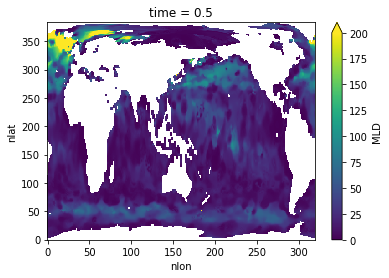

In [6]:
dso.MLD.isel(time=0).plot(vmin=0,vmax=200)